# Predicting Bike Rentals
In this project, we will work on a dataset from [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) on the number of bicycles people rent by the hour and day. We will try to predict the total number of bikes people rented in a given hour. To accomplish this, we'll create a few different machine learning models and evaluate their performance.

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')

In [4]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


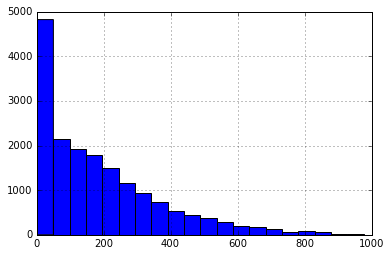

In [5]:
bike_rentals['cnt'].hist(bins = 20)

In [6]:
bike_rentals.corr().abs()['cnt'].sort_values(ascending = False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

## Calculating Features
It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

Here we are going to add a new column with labels for 'morning','afternoon','evening' and 'night' based on the 'hr' column. This will bundel similar times together, enabling the model to make better decisions.

In [14]:
def assign_label(hour):
    if (hour >= 6) & (hour < 12):
        label = 1
    elif (hour >= 12) & (hour < 18):
        label = 2
    elif (hour >= 18) & (hour <= 24):
        label = 3
    elif (hour >= 0) & (hour < 6):
        label = 4
    return label

In [17]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

## Splitting the data into Train and Test sets

We will use mean squared error (MSE) as the metric since we are predicting continous numerical values.

In [19]:
train = bike_rentals.sample(frac = .8, random_state = 1)
test = bike_rentals[~bike_rentals.index.isin(train.index)]

## Applying Linear Regression
Linear regression will probably work fairly well on this data since many of the columns are highly correlated with the 'cnt' column. But we need to ignore the 'casual' and 'registered' columns because 'cnt' is derived from them.

In [34]:
features = train.columns.tolist()
features.remove('cnt')
features.remove('casual')
features.remove('dteday')
features.remove('registered')

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [38]:
lr = LinearRegression()
lr.fit(train[features],train['cnt'])
predictions = lr.predict(test[features])
mse = mean_squared_error(test['cnt'],predictions)
mse

17052.124871247568

## Applying Decision Trees

Next we will apply decision tress algorithm and compare its error with the error from lienar regression.

In [40]:
from sklearn.tree import DecisionTreeRegressor

In [49]:
dt_mses = []
for n in range(1,20,2):
    dt = DecisionTreeRegressor(min_samples_leaf =n )
    dt.fit(train[features],train['cnt'])
    predictions = dt.predict(test[features])
    mse = mean_squared_error(test['cnt'],predictions)
    dt_mses.append(mse)
dt_mses

[3351.559838895282,
 2870.083890886715,
 2738.601566377414,
 2586.899379672401,
 2683.3206914874067,
 2801.535352164842,
 2844.4257101753947,
 2875.6970887957373,
 3010.2122118459206,
 3127.3952114921376]

The decision tree algorithms have lower mean sqaured errors than linear regression model in general, and as min_samples_leaf increases, the mse on test data decreases first and then increases.

## Applying Random Forests

Next we will apply random forest algorithm, which tend to be much more accurate than simple models, and much less overfit than decision trees.

In [50]:
from sklearn.ensemble import RandomForestRegressor

In [51]:
rf_mses = []
for n in range(1,20,2):
    rf = RandomForestRegressor(min_samples_leaf =n )
    rf.fit(train[features],train['cnt'])
    predictions = rf.predict(test[features])
    mse = mean_squared_error(test['cnt'],predictions)
    rf_mses.append(mse)
rf_mses

[1941.3273849252014,
 2070.8369010456213,
 2089.9080589916684,
 2154.8001662704664,
 2409.3955343502194,
 2450.795124535343,
 2548.0319295101804,
 2716.6446243153973,
 2774.0031137222463,
 2758.924275134578]

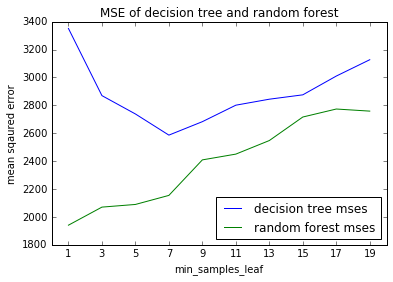

In [66]:
plt.plot(list(range(1,20,2)),dt_mses)
plt.plot(list(range(1,20,2)),rf_mses)
plt.legend(['decision tree mses','random forest mses'],loc= 'lower right')
plt.xticks(list(range(1,20,2)))
plt.xlabel('min_samples_leaf')
plt.ylabel('mean sqaured error')
plt.title('MSE of decision tree and random forest')
plt.show()

randome forest models have less mean sqaured error than decision tree models. But not like decision tree models which have a decrease-increase pattern, the mses of random forest models increase as min_samples_leaf increase from 1 to 19.